In [1]:

import os 
join = os.path.join

In [2]:
params_composite ={
    "r"         :  0.25,
    "h"         :  0.65,
    "z0"        :  0,
    "density"   : 8,
    "interface_factor"  :  1.2,
    "with_interface"    : False,
    "mirror"            : True,
    "check_jacobian"    : False,
}

params_ccx = {
    "epsilon" : 0.1,
    "x_fixed":True

}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [3]:

from djccx.read_dat import read_dat

def compute_vol_frac(dat_path):
    dat = read_dat(dat_path)
    vols = [ idat["df"]["volume"].sum() for idat in dat]
    vT = vols[1]
    v_yarns = vols[0]/vT
    v_matrix = 1 - v_yarns 
    return {
        "yarns"  : v_yarns,
        "matrix" : v_matrix,
    }

In [4]:
import numpy as np

In [5]:
np.linspace(0.2 ,0.3,5)

array([0.2  , 0.225, 0.25 , 0.275, 0.3  ])

In [6]:
r_span = np.linspace(0.15 ,0.25,5)
r_span

array([0.15 , 0.175, 0.2  , 0.225, 0.25 ])

In [7]:
from djccx.frd.readfrd import readfrd

In [8]:
import glob,os
join = os.path.join

In [9]:
frd_files = glob.glob(join("output","r_*","ccx","B1","*.frd"),recursive=True)
frd_files

['output\\r_00\\ccx\\B1\\main.frd',
 'output\\r_01\\ccx\\B1\\main.frd',
 'output\\r_02\\ccx\\B1\\main.frd',
 'output\\r_03\\ccx\\B1\\main.frd',
 'output\\r_04\\ccx\\B1\\main.frd']

In [10]:
dat_files = glob.glob(join("output","r_*","ccx","B1","*.dat"),recursive=True)

In [11]:
params_composite["h"]

0.65

In [12]:
ancho = params_composite["h"]
largo = 10 
A = ancho*largo
print("A = ",A)
print("ancho = ",ancho)
print("largo = ",largo)


def compute_Fapl(iffiles):
    ifrd = readfrd(iffiles)
    df = ifrd["data"]
    Fapl = np.sum(df["F2"]*(df["y"] > df["y"].mean()))

    return Fapl

Fapl = [compute_Fapl(f) for f in frd_files]
Sapl = [f/A for f in Fapl]
E_eff = [s / params["ccx"]["epsilon"] for s in Sapl]

A =  6.5
ancho =  0.65
largo =  10


In [13]:
vfracs = [compute_vol_frac(f) for f in dat_files]

In [14]:
vfracs

[{'yarns': np.float64(0.028995098915231114),
  'matrix': np.float64(0.9710049010847689)},
 {'yarns': np.float64(0.05482276237462205),
  'matrix': np.float64(0.945177237625378)},
 {'yarns': np.float64(0.08880225313039083),
  'matrix': np.float64(0.9111977468696092)},
 {'yarns': np.float64(0.1309385557076168),
  'matrix': np.float64(0.8690614442923832)},
 {'yarns': np.float64(0.18123000453476562),
  'matrix': np.float64(0.8187699954652343)}]

In [15]:
from validation.experimental import carbonfiber,resina,nucleo

carbon = carbonfiber()
Ecarbon_MPa = carbon["carbon"].iloc[0]["Young Modulus (GPa)"]*1e3
resina = resina()
nucleo = nucleo()

In [39]:
def analytical(r):

    h = params_composite["h"]
    Lx = 10
    
    f_y  = r["yarns"]
    f_m  = r["matrix"]

    radius = np.sqrt(f_y*h*Lx/(6*np.pi))  
    d = 2*radius

    E_c = Ecarbon_MPa
    E_m = resina["young modulus [MPa]"]

    f_c_ast = d/h
    f_c = 6*d/Lx 

    E_c_ast = 1/(f_c/E_c + (1-f_c)/E_m)

    E_eff = f_c_ast*E_c_ast + (1-f_c_ast)*E_m

    return E_eff

E_eff_analytical = [analytical(v) for v in vfracs]
v_carbon = [v["yarns"] for v in vfracs]

In [40]:
E_y = Ecarbon_MPa
E_m = resina["young modulus [MPa]"]
E_a = nucleo["young modulus [MPa]"]

In [41]:
print("Carbon",Ecarbon_MPa)
print("Resina",resina["young modulus [MPa]"])
print("Nucleo",nucleo["young modulus [MPa]"])

Carbon 230000.0
Resina 2549.7289999999994
Nucleo 800


In [42]:
from matplotlib import pyplot as plt

In [43]:
v_carbon = np.array(v_carbon)

(0.0, 3510.491521873329)

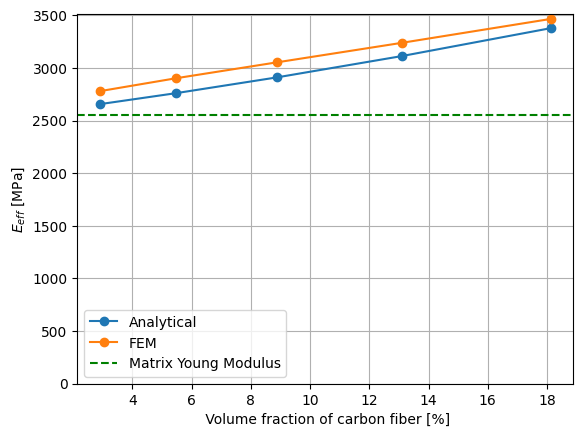

In [44]:
from matplotlib import pyplot as plt
plt.plot(100*v_carbon,E_eff_analytical,"o-",label="Analytical")
plt.plot(100*v_carbon,E_eff,"o-",label="FEM")

plt.axhline(y=E_m, color='g', linestyle='--', label='Matrix Young Modulus')
plt.ylabel(r"$E_{eff}$ [MPa]")
plt.xlabel(" Volume fraction of carbon fiber [%]")
plt.legend()
# grid
plt.grid()
plt.ylim([0,None])

Text(0, 0.5, 'Relative Error')

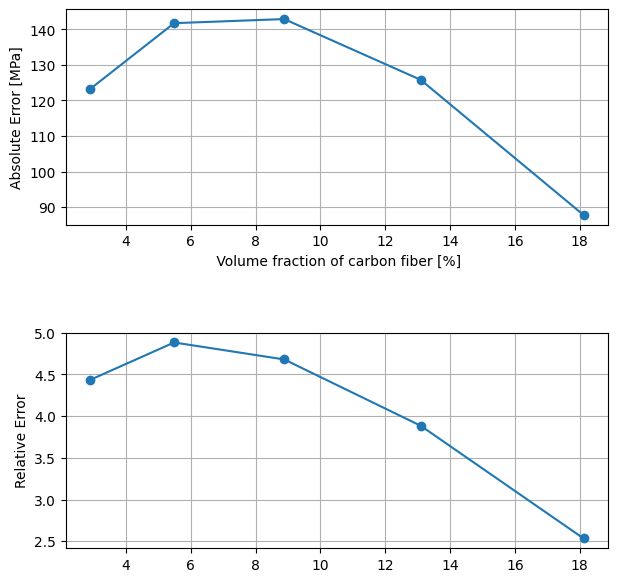

In [45]:
# error

error = np.abs(np.array(E_eff_analytical) - np.array(E_eff))

plt.figure( figsize=(7,7))
#subplot padd
plt.subplots_adjust(hspace=0.5)
plt.subplot(2,1,1)
plt.plot(100*v_carbon,error,"o-")

plt.ylabel("Absolute Error [MPa]")

plt.xlabel(" Volume fraction of carbon fiber [%]")

plt.grid()

plt.subplot(2,1,2)

error_rel = error / np.array(E_eff)

plt.plot(100*v_carbon,100*error_rel,"o-")
plt.grid()

plt.ylabel("Relative Error")


In [46]:
import pandas as pd
df_save = pd.DataFrame({"vfrac":vfrac_FEM,"E":E_eff})
df_save.to_csv("E_eff_analytical.csv",index=False)

NameError: name 'vfrac_FEM' is not defined

<BarContainer object of 6 artists>

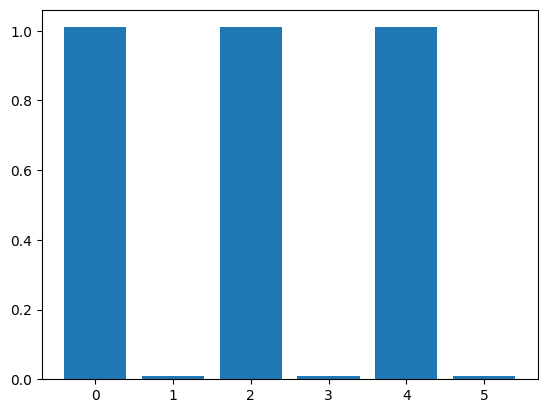

In [31]:
from matplotlib import pyplot as plt
import numpy as np
Nyarns = 5

fpar = lambda index: np.floor(np.mod(index-1,2)) + 1e-2

index_span = np.linspace(0,Nyarns,100)
index_span = np.arange(0,Nyarns+1,1)
plt.bar(index_span,fpar(index_span))